In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader

In [3]:
# this is to make sure that the mibi top level package is in the python path
import sys
sys.path.append("..")
from mibi.preprocess.mibi_image import *
from mibi.preprocess.mibi_plot import *
#from mibi.nets.utils import PatchMaker
from mibi.nets.bgsub.dataset import BackgroundSubtractionDataset
from mibi.nets.bgsub.network import BGSubAndDenoiser
from mibi.nets.bgsub.transform import transform_fovs

In [4]:
data_dir = '/Users/mschachter/data/CHOP_TMA_pilot'
images_dir = os.path.join(data_dir, 'extracted_subset')
channels_data_path = os.path.join(data_dir, 'info', 'channels.csv')

mp_images = dict()
for pdir in glob.glob(os.path.join(images_dir, 'Point*')):
    _,pname = os.path.split(pdir)
    print(f"Loading from {pdir}")
    mp_images[pname] = MIBIMultiplexImage.load_from_path(os.path.join(pdir, 'TIFs'), channels_data_path)


Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point4
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point19
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point21
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point8
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point22


In [5]:
mp_img = mp_images['Point21']
mp_img.df_channel

,Isotope,Label,Start,Stop,BaselineStart,BaselineEnd,Batch,Description
0,12,12_C,11.7,12.0,11.5,11.6,0,Carbon
1,23,23_Na,22.7,23.0,22.5,22.6,0,Sodium
2,28,28_Si,27.7,28.0,27.5,27.6,0,Silicon
3,31,31_P,30.7,31.0,30.5,30.6,0,Phosphorous
4,38,38_calib,34.8,38.0,34.5,34.6,0,Calibration
5,40,40_Ca,39.7,40.0,39.5,39.6,0,Calcium
6,56,56_Fe,55.7,56.0,55.5,55.6,0,Iron
7,115,nuclear,114.7,115.0,114.5,114.6,0,Nuclear
8,147,B7H3,146.7,147.1,146.5,146.6,0,B7H3 T-cell Checkpoint
9,150,EGFR,149.7,150.1,149.5,149.6,0,Growth Factor Receptor


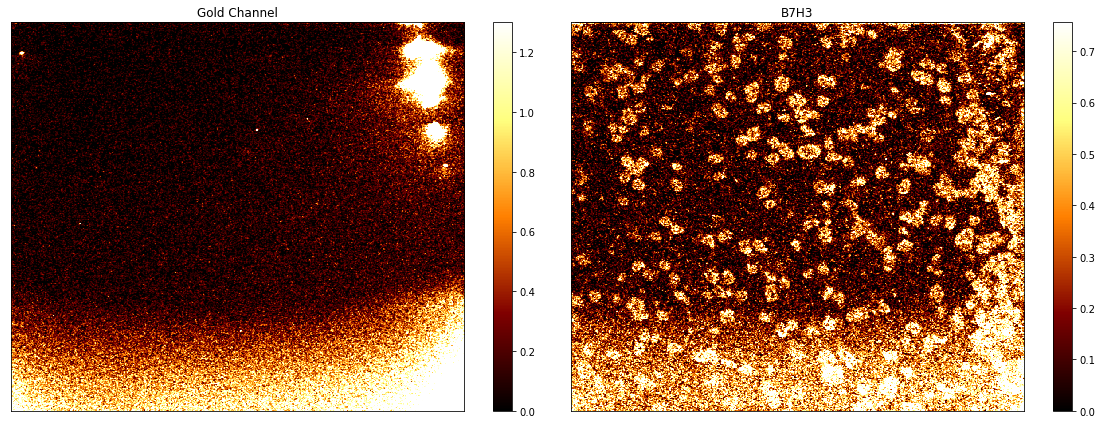

In [6]:
gold_chan_idx = mp_img.label_to_index['197_Au']
egfr_idx = mp_img.label_to_index['B7H3']
bg_img = mp_img.X['raw'][gold_chan_idx]
chan_img = mp_img.X['raw'][egfr_idx]

fig = plt.figure(figsize=(16, 6))
ax = plt.subplot(1, 2, 1)
plot_img(bg_img, transform=False)
plt.title('Gold Channel')
ax = plt.subplot(1, 2, 2)
plot_img(chan_img, transform=False)
plt.title('B7H3')
plt.tight_layout()

In [7]:
relu = lambda x: x * (x > 0)
img1 = relu(np.random.randn(1024, 1024))
img2 = 0.3*img1 + 0.7*relu(np.random.randn(1024, 1024))
img3 = relu(np.random.randn(1024, 1024))

img1 = torch.tensor(img1)
img2 = torch.tensor(img2)
img3 = torch.tensor(img3)

norm = torch.linalg.norm

cos_loss = lambda x,y: torch.sum((x*y) / (torch.norm(x)*norm(y)) )
logcos_loss = lambda x,y: torch.log(torch.sum(x*y)) - torch.log(norm(x)) - torch.log(norm(y))
logcos_loss2 = lambda x,y: torch.log(torch.sum(x*y)) - \
                0.5*torch.log(torch.sum(torch.pow(x, 2))) - \
                0.5*torch.log(torch.sum(torch.pow(y, 2)))

c1 = cos_loss(img1, img2)
c2 = torch.log(c1)
c3 = logcos_loss(img1, img2)
c4 = logcos_loss2(img1, img2)

print('c1=',c1)
print('c2=',c2)
print('c3=',c3)
print('c4=',c4)

c1= tensor(0.6193, dtype=torch.float64)
c2= tensor(-0.4792, dtype=torch.float64)
c3= tensor(-0.4792, dtype=torch.float64)
c4= tensor(-0.4792, dtype=torch.float64)


In [8]:
from pytorch_msssim import SSIM, MS_SSIM

sim_matrices = dict()
num_pixels = 1024.**2

def make_sim_mat(loss_func):
    chan_indices = [gold_chan_idx] + list(mp_img.included_channel_indices())
    
    #chan_max = mp_img.X['raw'][chan_indices, :, :].max()
    
    sim_mat = np.zeros([len(chan_indices), len(chan_indices)])
    for k,chan_idx1 in enumerate(chan_indices):
        img1 = torch.tensor(mp_img.X['raw'][chan_idx1]).unsqueeze(0).unsqueeze(0)
        #sim_mat[k, k] = ssim_loss(img1, img1)
        for j in range(k):
            chan_idx2 = chan_indices[j]

            img2 = torch.tensor(mp_img.X['raw'][chan_idx2]).unsqueeze(0).unsqueeze(0)
            sim = loss_func(img1, img2).detach().numpy()
            sim_mat[k, j] = sim
            sim_mat[j, k] = sim
    return sim_mat

#ssim_loss = SSIM(data_range=chan_max, win_size=25, channel=1)

mse_loss = lambda x,y: torch.mean(torch.pow((x / norm(x)) - (y / norm(y)), 2))

cos_sim = lambda x,y: torch.sum((x*y) / (norm(x)*norm(y)) )

logcos_sim = lambda x,y: torch.log(torch.sum(x*y)) - \
                0.5*torch.log(torch.sum(torch.pow(x, 2))) - \
                0.5*torch.log(torch.sum(torch.pow(y, 2)))

#sim_matrices['ssim'] = make_sim_mat(ssim_loss)
sim_matrices['mse'] = make_sim_mat(mse_loss)
sim_matrices['cos'] = make_sim_mat(cos_sim)
sim_matrices['logcos'] = make_sim_mat(logcos_sim)
    

In [9]:
X = img1.unsqueeze(0).unsqueeze(0).float()
Y = img2.unsqueeze(0).unsqueeze(0).float()
Z = img3.unsqueeze(0).unsqueeze(0).float()

net = BGSubAndDenoiser()

XYout = net(X, Y)
XYout.shape

torch.Size([1, 1, 1024, 1024])

In [10]:
logcos_sim = lambda x,y: torch.log(torch.sum(x*y)) - \
                0.5*torch.log(torch.sum(torch.pow(x, 2))) - \
                0.5*torch.log(torch.sum(torch.pow(y, 2)))

logcos_loss = lambda x,y,z: torch.log(torch.sum(x*y)) + \
                            torch.log(torch.sum(x*z)) - \
                            torch.log(torch.sum(torch.pow(x, 2))) - \
                            0.5*torch.log(torch.sum(torch.pow(y, 2))) - \
                            0.5*torch.log(torch.sum(torch.pow(z, 2)))

loss1 = 0.5*logcos_sim(X, Y) - 0.5*logcos_sim(X, Z)

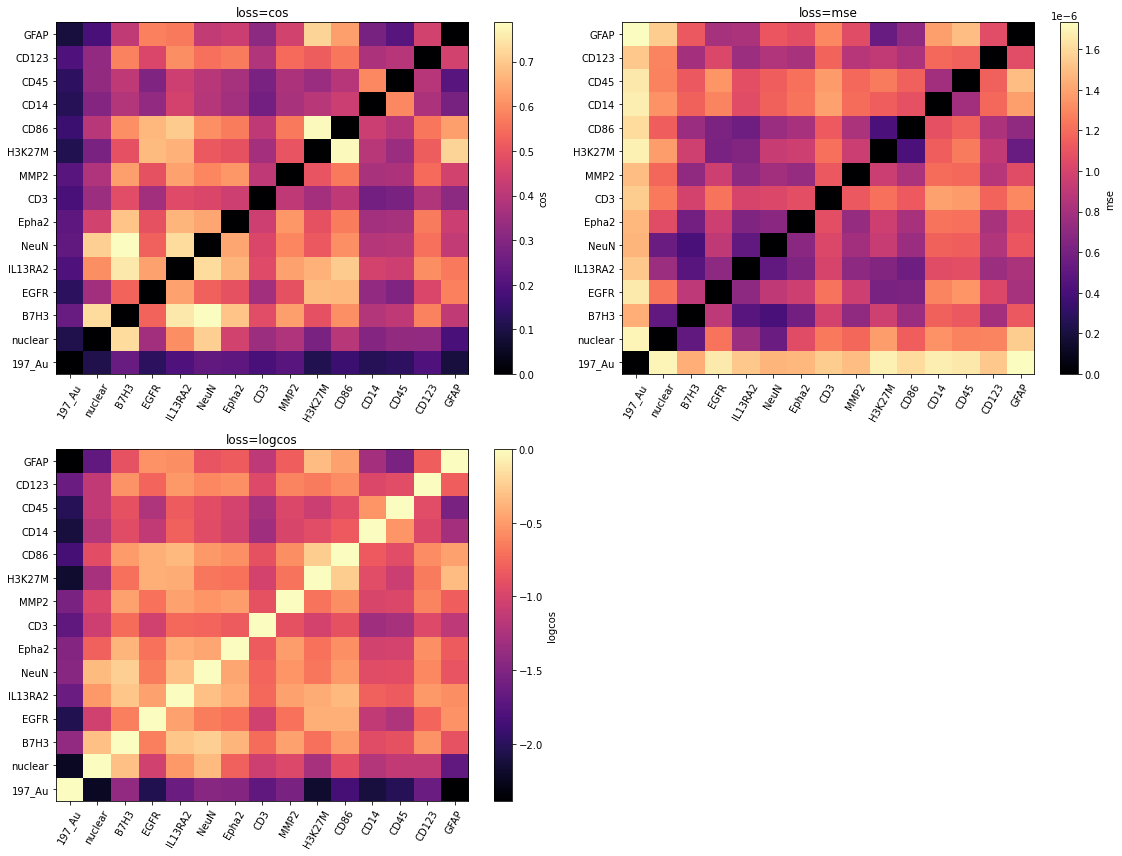

In [11]:
nrows = int(np.ceil(len(sim_matrices) / 2))
ncols = 2

chan_indices = [gold_chan_idx] + list(mp_img.included_channel_indices())
labels = [mp_img.df_channel.loc[chan_idx]['Label'] for chan_idx in chan_indices]

fig = plt.figure(figsize=(16, nrows*6))
for k,loss_name in enumerate(['cos', 'mse', 'logcos']):
    ax = plt.subplot(nrows, ncols, k+1)
    plt.imshow(sim_matrices[loss_name], interpolation='nearest', aspect='auto', cmap=plt.cm.magma, origin='lower')
    plt.xticks(np.arange(len(chan_indices)), labels, rotation=60)
    plt.yticks(np.arange(len(chan_indices)), labels)
    plt.colorbar(label=loss_name)
    plt.title(f"loss={loss_name}")
    plt.autoscale(tight=True)

plt.tight_layout()

In [12]:
"""
X,Y = ds[0]
print('X.shape=',X.shape)
print('Y.shape=',Y.shape)

fig = plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 2, 1)
plot_img(X.numpy().squeeze())
ax = plt.subplot(1, 2, 2)
plot_img(Y.numpy().squeeze())
plt.tight_layout()
"""

"\nX,Y = ds[0]\nprint('X.shape=',X.shape)\nprint('Y.shape=',Y.shape)\n\nfig = plt.figure(figsize=(16, 5))\nax = plt.subplot(1, 2, 1)\nplot_img(X.numpy().squeeze())\nax = plt.subplot(1, 2, 2)\nplot_img(Y.numpy().squeeze())\nplt.tight_layout()\n"

In [13]:
"""
def tensor_mem(t):
    nelems = np.prod(t.shape)
    mem_gb = (nelems*4) / 1000.**3
    print(f"Mem: {mem_gb:.2f}GB, Shape: ({','.join([str(s) for s in t.shape])})")
tensor_mem(ds.gold_patches['Point4'])
tensor_mem(ds.chan_patches['Point4'])
"""

'\ndef tensor_mem(t):\n    nelems = np.prod(t.shape)\n    mem_gb = (nelems*4) / 1000.**3\n    print(f"Mem: {mem_gb:.2f}GB, Shape: ({\',\'.join([str(s) for s in t.shape])})")\ntensor_mem(ds.gold_patches[\'Point4\'])\ntensor_mem(ds.chan_patches[\'Point4\'])\n'

# TODO: CCA within FOVs to see shared components - are they tissue, gold, something else?

In [14]:
import pandas as pd
import glob
import json
import os

In [15]:
data_dir = '/Users/mschachter/data/bgsub'
all_dicts = list()
for fname in glob.glob(os.path.join(data_dir, 'hyperparam_logcos_search*.json')):
    with open(fname, 'r') as f:
        all_dicts.append(json.load(f))

In [16]:
all_dicts[0]

{'learning_rate': 0.001,
 'weight_decay': 1.0,
 'epochs': 10,
 'batch_size': 30,
 'validation_loss_mean': -59.29804992675781,
 'validation_loss_sd': 1.1685774326324463,
 'training_elapsed_time': 351.22799944877625,
 'model_desc': 'hyperparam_logcos_search_3_4',
 'energy_coef': 1.0}

In [17]:
data = {'energy_coef':list(), 'learning_rate':list(), 'weight_decay':list(), 'epochs':list(),
        'validation_loss_mean':list(), 'training_elapsed_time':list(), 'hparam_key':list(), 'run':list()}
for d in all_dicts:
    for k in ['energy_coef', 'learning_rate', 'weight_decay', 'epochs', 'validation_loss_mean',
              'training_elapsed_time']:
        data[k].append(d[k])
    mdesc = d['model_desc']
    x = mdesc.split('_')
    data['hparam_key'].append(int(x[-2]))
    data['run'].append(int(x[-1]))
    
df = pd.DataFrame(data)

In [18]:
df.sort_values('validation_loss_mean')

,energy_coef,learning_rate,weight_decay,epochs,validation_loss_mean,training_elapsed_time,hparam_key,run
7,1.000,0.001,0.0,10,-65.659981,350.645255,1,2
2,1.000,0.001,0.0,10,-65.112030,351.680157,1,3
4,1.000,0.001,1.0,10,-63.054111,350.567743,3,2
10,1.000,0.001,1.0,10,-63.044476,350.323930,3,3
6,1.000,0.001,1.0,10,-61.813614,350.958327,3,0
5,1.000,0.001,0.0,10,-61.564556,351.111885,1,0
8,1.000,0.001,0.0,10,-60.964645,351.480263,1,4
0,1.000,0.001,1.0,10,-59.298050,351.227999,3,4
3,1.000,0.001,1.0,10,-57.853474,351.209396,3,1
9,1.000,0.001,0.0,10,-24.584660,350.325308,1,1


In [19]:
df_agg = df.groupby('hparam_key').aggregate(np.mean)
df_agg.sort_values('validation_loss_mean')

,energy_coef,learning_rate,weight_decay,epochs,validation_loss_mean,training_elapsed_time,run
hparam_key,,,,,,,
3,1.000,0.001,1.0,10.0,-61.012745,350.857479,2.0
1,1.000,0.001,0.0,10.0,-55.577174,351.048574,2.0
2,0.001,0.001,1.0,10.0,0.922769,350.233879,3.0


<AxesSubplot:xlabel='epoch'>

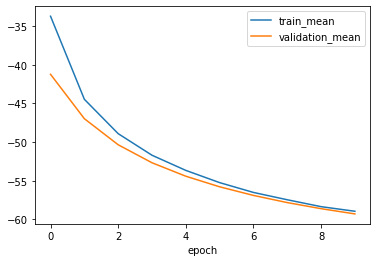

In [20]:
fname = os.path.join(data_dir, 'hyperparam_logcos_search_3_4_losses.csv')
df_loss = pd.read_csv(fname)
fig = plt.figure()
ax = plt.gca()
df_loss.plot(x='epoch', y='train_mean', ax=ax)
df_loss.plot(x='epoch', y='validation_mean', ax=ax)

In [21]:
#df_agg.loc[9]

In [30]:
model_path = '/Users/mschachter/data/bgsub/hyperparam_logcos_search_3_0_network.pytorch.zip'
net = BGSubAndDenoiser.load_from_file(model_path)

In [31]:
ds = BackgroundSubtractionDataset(images_dir, channels_data_path)

Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point4
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point19
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point21
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point8
Loading from /Users/mschachter/data/CHOP_TMA_pilot/extracted_subset/Point22


In [32]:
trans_imgs = transform_fovs(ds, ['Point4'], net)

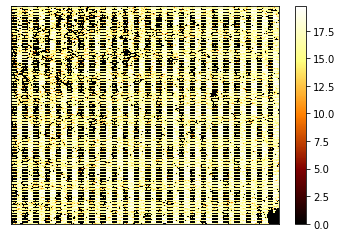

In [33]:
plot_img(trans_imgs['Point4']['EGFR'].detach().numpy())